In [1]:
import os
from glob import glob
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2025-07-01 17:09:49.571256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751389790.819127  113454 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751389791.171824  113454 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751389794.162424  113454 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751389794.162453  113454 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751389794.162455  113454 computation_placer.cc:177] computation placer alr

In [2]:
BASE_DIR         = r"../data/RWF-2000"
TRAIN_DIR        = os.path.join(BASE_DIR, "train")
CLASSES_LIST     = ["NonFight", "Fight"]
IMAGE_SIZE       = (64, 64)
SEQUENCE_LENGTH  = 16
TEST_SIZE        = 0.2
VAL_SPLIT        = 0.2
BATCH_SIZE       = 8
EPOCHS           = 50
HOG_PARAMS = {
    'win_size':     (64, 64),
    'block_size':   (16, 16),
    'block_stride': (8, 8),
    'cell_size':    (8, 8),
    'nbins':        9
}


In [3]:
hog = cv2.HOGDescriptor(
    HOG_PARAMS['win_size'],
    HOG_PARAMS['block_size'],
    HOG_PARAMS['block_stride'],
    HOG_PARAMS['cell_size'],
    HOG_PARAMS['nbins']
)
# Determine feature dimension
dummy = np.zeros(HOG_PARAMS['win_size'], dtype=np.uint8)
feat_dim = hog.compute(dummy).flatten().shape[0]
print(f"HOG feature dimension: {feat_dim}")


HOG feature dimension: 1764


In [4]:
def extract_hog_sequence(video_path, seq_len=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // seq_len, 1)
    descriptors = []
    for i in range(seq_len):
        cap.set(cv2.CAP_PROP_POS_FRAMES, step * i)
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, HOG_PARAMS['win_size'])
        desc = hog.compute(gray).flatten()
        descriptors.append(desc)
    cap.release()
    return np.stack(descriptors, axis=0) if len(descriptors) == seq_len else None


In [5]:
def load_dataset():
    X, y, paths = [], [], []
    for idx, cls in enumerate(CLASSES_LIST):
        folder = os.path.join(TRAIN_DIR, cls)
        for vid_path in glob(os.path.join(folder, "*.avi")):
            seq = extract_hog_sequence(vid_path)
            if seq is not None:
                X.append(seq)
                y.append(idx)
                paths.append(vid_path)
    X = np.array(X)
    y = np.array(y)
    return X, y, paths

In [6]:
# %% Kiểm tra số lượng file và label trước khi train
X, y, video_paths = load_dataset()

print(f"Total samples: {len(X)}")
unique, counts = np.unique(y, return_counts=True)
for cls_idx, cnt in zip(unique, counts):
    print(f"{CLASSES_LIST[cls_idx]:10s}: {cnt}")

# Optional: kiểm tra xem có mismatch giữa X và y không
assert len(X) == len(y), "Số lượng X và y không bằng nhau!"


Total samples: 1375
NonFight  : 800
Fight     : 575


In [7]:
def create_model(seq_len, feat_dim, num_classes=2):
    inp = Input(shape=(seq_len, feat_dim), name="hog_sequence")

    # 1) Bidirectional LSTM with full sequence output
    x = Bidirectional(
        LSTM(64, return_sequences=True),
        name="bilstm"
    )(inp)

    # 2) Multi-Head Self-Attention
    attn = MultiHeadAttention(
        num_heads=4, key_dim=32,
        name="multihead_attn"
    )(x, x)

    # 3) Skip-connection + Normalization
    x = LayerNormalization(name="layer_norm")(x + attn)

    # 4) Pooling to fixed-size
    x = GlobalAveragePooling1D(name="global_avg_pool")(x)
    x = Dropout(0.5, name="dropout_1")(x)

    # 5) Dense layers
    x = Dense(64, activation="relu", name="dense_1")(x)
    x = Dropout(0.5, name="dropout_2")(x)

    # Output layer for binary classification
    out = Dense(num_classes, activation="softmax", name="classifier")(x)

    model = Model(inp, out, name="HOG_MH_BiLSTM")
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.summary()
    return model

Loaded 1375 videos: sequence shape=(16, 1764), distribution=[800 575]


I0000 00:00:1751390675.836227  113454 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "HOG_MH_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ hog_sequence        │ (None, 16, 1764)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 16, 128)   │    936,448 │ hog_sequence[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 16, 128)   │     66,048 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 128)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 16, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 128)       │          0 │ layer_norm[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_avg_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,011,138 (3.86 MB)

 Trainable params: 1,011,138 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1751390685.393973  116688 cuda_dnn.cc:529] Loaded cuDNN version 90300


109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4848 - loss: 0.9847

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4851 - loss: 0.9822 - val_accuracy: 0.5591 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5484 - loss: 0.7163 - val_accuracy: 0.5591 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5591 - loss: 0.6943 - val_accuracy: 0.5591 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5692 - loss: 0.6893 - val_accuracy: 0.5591 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5313 - loss: 0.6982

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5316 - loss: 0.6981 - val_accuracy: 0.5591 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6163 - loss: 0.6970 - val_accuracy: 0.5591 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5766 - loss: 0.6867

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5768 - loss: 0.6865 - val_accuracy: 0.5591 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5476 - loss: 0.6922 - val_accuracy: 0.5591 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6130 - loss: 0.6677 - val_accuracy: 0.5591 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 10/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6145 - loss: 0.6616

110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6138 - loss: 0.6617 - val_accuracy: 0.5591 - val_loss: 0.6630 - learning_rate: 0.0010
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5877 - loss: 0.6687

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5877 - loss: 0.6686 - val_accuracy: 0.5864 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6242 - loss: 0.6522 - val_accuracy: 0.5682 - val_loss: 0.6737 - learning_rate: 0.0010
Epoch 13/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6422 - loss: 0.6244

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6416 - loss: 0.6247 - val_accuracy: 0.6455 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6094 - loss: 0.6328 - val_accuracy: 0.5591 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 15/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5974 - loss: 0.6426

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5977 - loss: 0.6424 - val_accuracy: 0.6409 - val_loss: 0.6210 - learning_rate: 0.0010
Epoch 16/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6216 - loss: 0.5926

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6215 - loss: 0.5928 - val_accuracy: 0.5545 - val_loss: 0.6201 - learning_rate: 0.0010
Epoch 17/50
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6397 - loss: 0.5547

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6398 - loss: 0.5554 - val_accuracy: 0.6545 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 18/50
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6809 - loss: 0.5314

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6806 - loss: 0.5322 - val_accuracy: 0.6227 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 19/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6940 - loss: 0.5449 - val_accuracy: 0.6364 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 20/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6713 - loss: 0.5470 - val_accuracy: 0.6591 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 21/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7052 - loss: 0.5162 - val_accuracy: 0.6545 - val_loss: 0.6402 - learning_rate: 0.0010
Epoch 22/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6967 - loss: 0.5276 - val_accuracy: 0.6545 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 23/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7619 - loss: 0.4990

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7615 - loss: 0.4989 - val_accuracy: 0.6455 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 24/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6453 - loss: 0.5609 - val_accuracy: 0.6045 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 25/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7345 - loss: 0.4972 - val_accuracy: 0.6727 - val_loss: 0.5910 - learning_rate: 0.0010
Epoch 26/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7484 - loss: 0.4554 - val_accuracy: 0.6818 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 27/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7572 - loss: 0.4694

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7572 - loss: 0.4694 - val_accuracy: 0.7000 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 28/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7120 - loss: 0.4873 - val_accuracy: 0.6545 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 29/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7529 - loss: 0.5043 - val_accuracy: 0.6727 - val_loss: 0.5922 - learning_rate: 0.0010
Epoch 30/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7654 - loss: 0.4571 - val_accuracy: 0.6182 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 31/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5158 - loss: 0.6702 - val_accuracy: 0.6909 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 32/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7654 - loss: 0.4780 - val_accuracy: 0.7182 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 33/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8273 - loss: 0.3835 

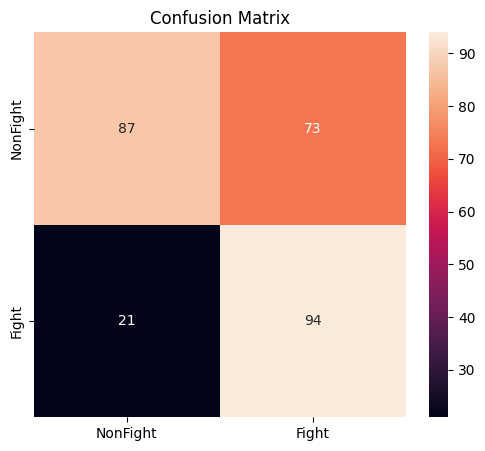

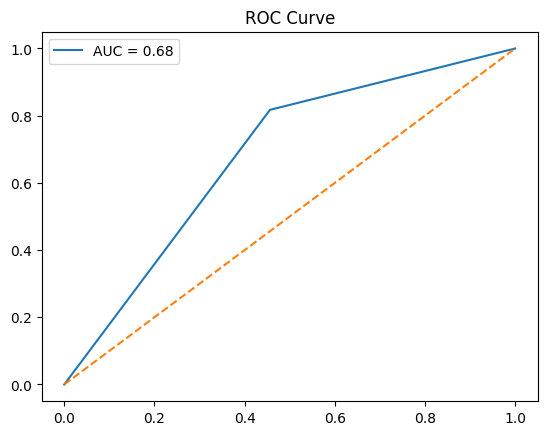

In [8]:
if __name__ == '__main__':
    # Load data
    X, y, video_paths = load_dataset()
    print(f"Loaded {len(X)} videos: sequence shape={X.shape[1:]}, distribution={np.bincount(y)}")

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        stratify=y,
        random_state=42
    )
    y_train_cat = to_categorical(y_train, num_classes=len(CLASSES_LIST))
    y_test_cat  = to_categorical(y_test,  num_classes=len(CLASSES_LIST))

    # Build updated model
    model = create_model(SEQUENCE_LENGTH, feat_dim, num_classes=len(CLASSES_LIST))

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=1e-5),
        ModelCheckpoint('hog_mh_bdlstm_best.h5', save_best_only=True)
    ]

    # Train model
    history = model.fit(
        X_train, y_train_cat,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        callbacks=callbacks
    )

    # Evaluate on test set
    loss, acc = model.evaluate(X_test, y_test_cat)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

    # Metrics
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=CLASSES_LIST))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.title('Confusion Matrix')
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], '--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [9]:


model = create_model(SEQUENCE_LENGTH, feat_dim, num_classes=2)
model.load_weights('hog_mh_bdlstm_best.h5')

# Định nghĩa signature cho serving
@tf.function(input_signature=[
    tf.TensorSpec([None, SEQUENCE_LENGTH, feat_dim], tf.float32, name="hog_input")
])
def serve_fn(inputs):
    probs = model(inputs, training=False)
    return {"scores": probs}

# Xuất SavedModel
tf.saved_model.save(
    model,
    export_dir="mh_bilstm_savedmodel",
    signatures={"serving_default": serve_fn}
)
print("SavedModel ready at ./mh_bilstm_savedmodel")


Model: "HOG_MH_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ hog_sequence        │ (None, 16, 1764)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 16, 128)   │    936,448 │ hog_sequence[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 16, 128)   │     66,048 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 128)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 16, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 128)       │          0 │ layer_norm[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_avg_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,011,138 (3.86 MB)

 Trainable params: 1,011,138 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

INFO:tensorflow:Assets written to: mh_bilstm_savedmodel/assets


INFO:tensorflow:Assets written to: mh_bilstm_savedmodel/assets


SavedModel ready at ./mh_bilstm_savedmodel
